In [43]:
import os
import sys
import csv
import pickle
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from time import perf_counter as timer
from concurrent.futures import ProcessPoolExecutor
from src import *

In [44]:
model_number: int = 2
new_run: bool = False

In [45]:
data = Data()
thermal = Thermal()
renewable = Renewable()
demand = Demand()
commitment = Commitment()
data.load_thermal(thermal)
data.load_renewable_capacity(renewable)
data.load_renewable_generation(renewable)
data.load_demand(demand)
data.load_commitment_decision(commitment)

/disk/disk3/gyeongmin/pse_project/src/data.py:89: RuntimeWarning: invalid value encountered in multiply
  renewable.wind_generation = wind_ratio[:, renewable.wind_idx_bus] * renewable.wind_capacity


In [46]:
if model_number == 1:
    with open(Path.cwd() / "data" / "outputs" / "model1" / "object_results.pkl", "rb") as file:
        results = pickle.load(file)

if model_number == 2:
    with open(Path.cwd() / "data" / "outputs" / "model2" / "object_results.pkl", "rb") as file:
        results = pickle.load(file)

if new_run:
    results = Results(thermal, renewable, commitment)
    def parallel(idx_hour):
        solver = Solver(thermal, renewable, demand, commitment, results)
        solver.solve(idx_hour)
        
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        list(executor.map(parallel, range(8760)))
    results.process_outputs()

---
---
---

**HELPERS & ADDITIONAL DATA & ALPHAS (MODEL 2 DEVELOPMENT)**

In [47]:
# for monthly plots
month_names = {0: "January", 1: "February", 2: "March", 3: "April", 4: "May", 5: "June", 6: "July", 7: "August", 8: "September", 9: "October", 10: "November", 11: "December"}
idxs_hour_month_start = np.array([0, 744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016])
idxs_hour_month_end = np.concatenate((np.delete(idxs_hour_month_start, 0), np.array([8760]))) - 1
iterators_month = [range(start, (end + 1)) for start, end in zip(idxs_hour_month_start, idxs_hour_month_end)]
days_in_months = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
# np.searchsorted(idxs_hour_month_start, idx_hour, side='right') - 1 # returns 0-index month given idx_hour

# for day plots
day_names = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
days_of_year = (np.arange(8760) // 24 + 5) % 7
days_cmap = days_cmap = [plt.colormaps["jet_r"](i / 6) for i in range(7)]

In [48]:
def get_from_12_to_8760(input, iterators_month=iterators_month): # 12 month input, for PLOTTING with 8760 hours as xaxis
    output = []
    for idx_month, iterator_month in enumerate(iterators_month):
        output += [float(input[idx_month])] * len(iterator_month)
    return np.array(output)

def get_monthly_means_daily_max(smp_daily_max, days_in_months=days_in_months): # for 365 input # GET 12 MONTHLY
    smp_daily_max_split = np.split(smp_daily_max, np.cumsum(days_in_months)[:-1])
    return np.array([month.mean() for month in smp_daily_max_split])

In [49]:
# 2022 hourly (mainland) SMP from EPSIS 
smp_real = np.load(Path.cwd() / "data" / "inputs" / "EPSIS" / "smp_2022.npy") # 8760

# KRW/GJ, GENCOs & IPPs, fuel + supply fee (total), monthly price in 2022, from https://www.kogas.or.kr/site/koGas/1040402000000
df = pd.read_excel(Path.cwd() / "data" / "inputs" / "KOGAS" / "lng_2022.xlsx", header=None, engine='openpyxl', sheet_name=0)
lng_real_12 = df.iloc[9].iloc[2:26:2].astype(float).to_numpy()
lng_real_8760 = get_from_12_to_8760(lng_real_12)

In [50]:
smp_real_daily_max = smp_real.reshape((-1, 24)).max(axis=1) # 365 len smp_real daily max values # min is around 130
smp_results_daily_max = results.smp.reshape((-1, 24)).max(axis=1) # 365 len smp_results daily max values # min is around 57 so we are good

smp_real_monthly_mean_daily_max = get_monthly_means_daily_max(smp_real_daily_max) # 12 len smp_real monthly mean of daily max values
smp_results_monthly_mean_daily_max = get_monthly_means_daily_max(smp_results_daily_max) # 12 len smp_results monthly mean of daily max values

smp_real_monthly_mean_daily_max_8760 = get_from_12_to_8760(smp_real_monthly_mean_daily_max)
smp_results_monthly_mean_daily_max_8760 = get_from_12_to_8760(smp_results_monthly_mean_daily_max)

In [51]:
# we now obtain the scaling factor for LNG C1 (linear coefficient)
# model 2 will recompute the optimization after this tuning
# i almost did bi-layer optimization with the outer one just naive... just for this project it's no point
if model_number == 1:
    alpha = smp_real_monthly_mean_daily_max / smp_results_monthly_mean_daily_max # scaling factor # I know that setting jan SMP close then scaling with lng_real ratio (jan = 1) would be more justifiable but anyways both are justifiable

---
---
---

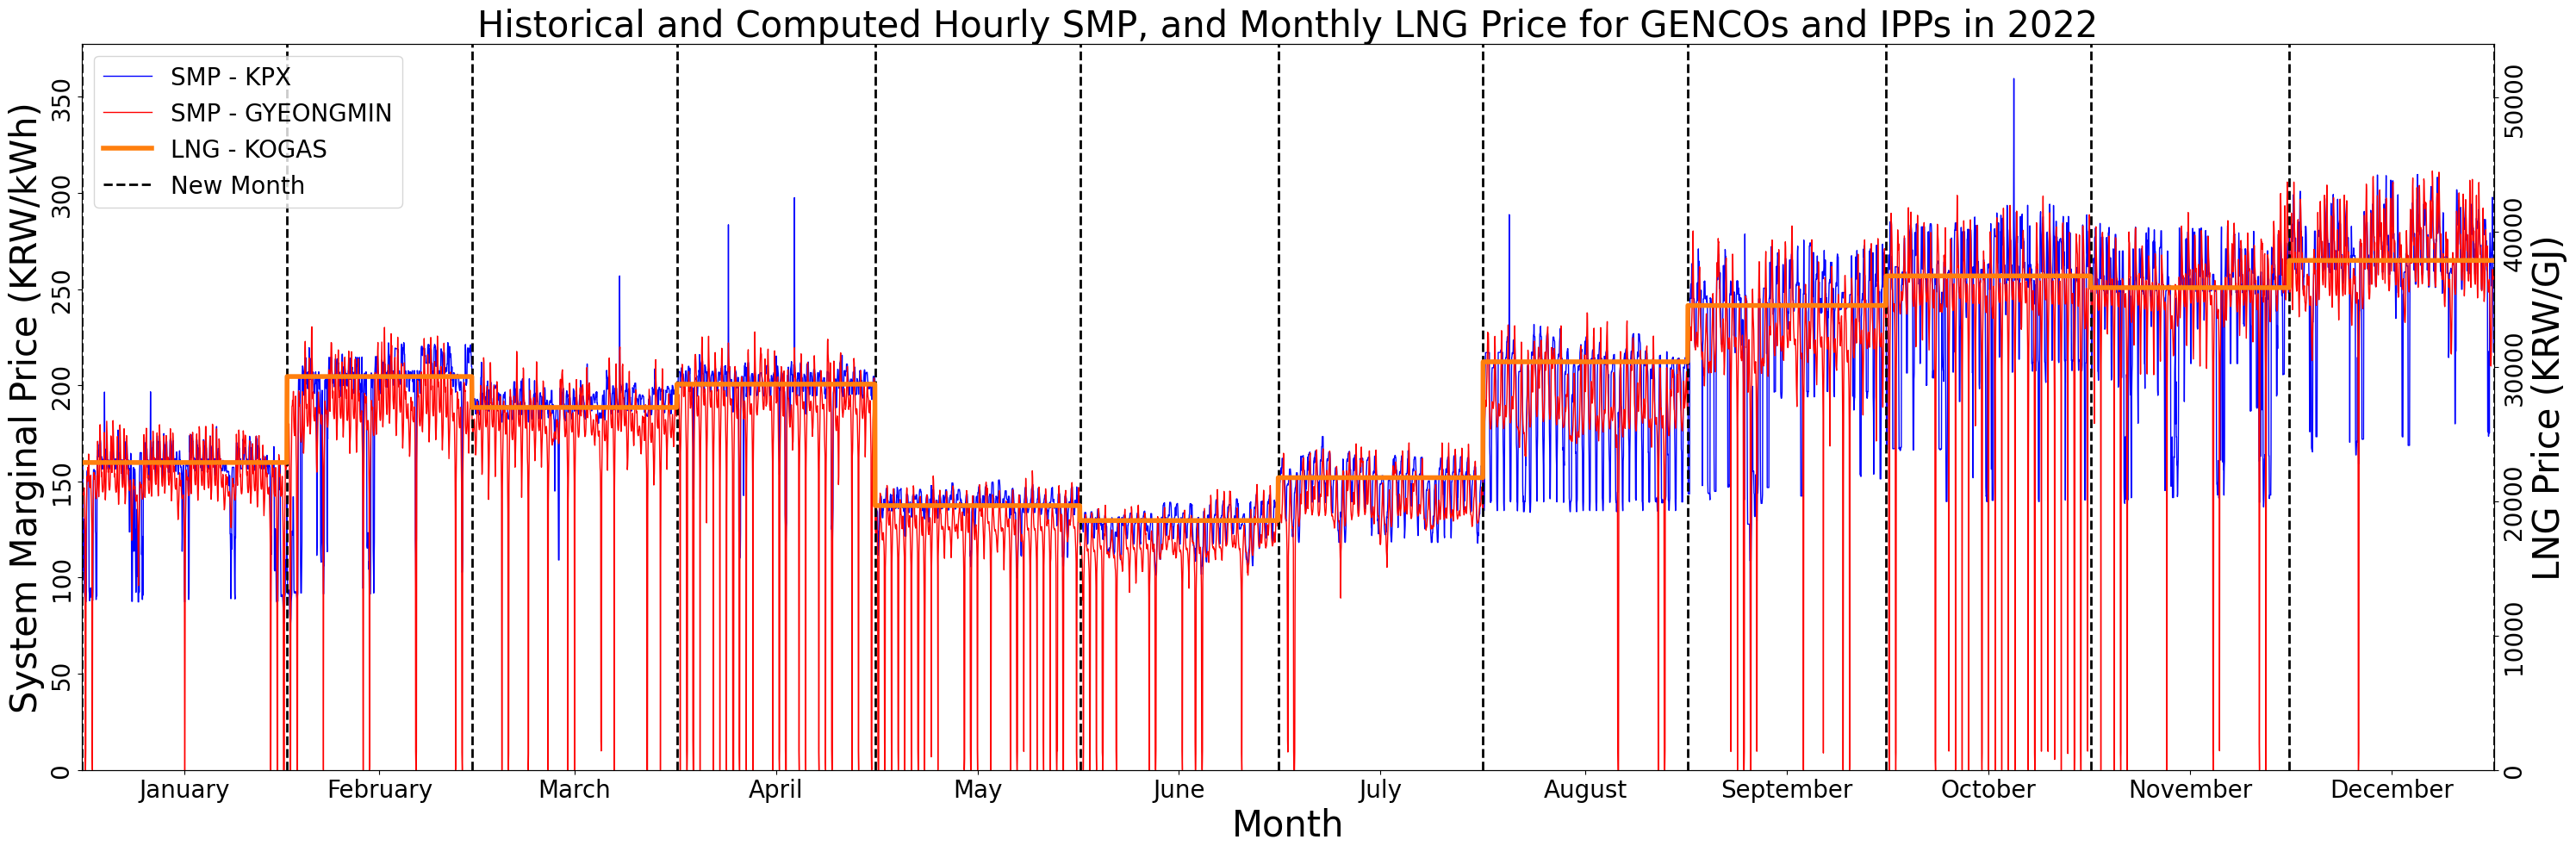

In [52]:
idx_hour_spc_start, idx_hour_spc_end = 0, 8759 # idxs_hour_month_start[3], idxs_hour_month_end[5]
iterator = range(idx_hour_spc_start, (idx_hour_spc_end + 1))

fig, ax1 = plt.subplots(1, 1, figsize=(30, 10))
ax2 = ax1.twinx()
# SMP
l0, = ax1.plot(iterator, smp_real[idx_hour_spc_start:idx_hour_spc_end+1], color="blue", label="SMP - KPX", linewidth=1)
l1, = ax1.plot(iterator, results.smp[idx_hour_spc_start:idx_hour_spc_end+1], color="red", label="SMP - GYEONGMIN", linewidth=1)
# MONTH
ymin, ymax = ax1.get_ylim()
ymin = ymin if results.smp[idx_hour_spc_start:idx_hour_spc_end+1].min() < 0 else 0
l3= ax1.vlines(x=idxs_hour_month_start.tolist() + [idxs_hour_month_end[-1]], ymin=ymin, ymax=ymax, colors="black", linewidth=2, linestyles="--", label="New Month")
# LNG
l2, = ax2.plot(iterator, lng_real_8760[idx_hour_spc_start:idx_hour_spc_end+1], color="tab:orange", label="LNG - KOGAS", linewidth=4)
# TITLE
ax1.set_title("Historical and Computed Hourly SMP, and Monthly LNG Price for GENCOs and IPPs in 2022", fontsize=30)
ax1.set_xlabel("Month", fontsize=30)
ax1.set_ylabel("System Marginal Price (KRW/kWh)", fontsize=30)
ax2.set_ylabel("LNG Price (KRW/GJ)", fontsize=30)
# TICKS
ax1.set_xticks(((idxs_hour_month_start + idxs_hour_month_end) / 2).tolist())
ax1.set_xticklabels(list(month_names.values()))
ax1.tick_params(axis='both', labelsize=20)
[label.set_rotation(90) or label.set_va('center') for label in ax1.get_yticklabels()]
[label.set_rotation(90) or label.set_va('center') or label.set_fontsize(20) for label in ax2.get_yticklabels()]
# LEGEND
lines = [l0, l1, l2, l3]
ax1.legend(lines, [line.get_label() for line in lines], loc="upper left", fontsize=20)
# LIM
ax1.set_xlim((idx_hour_spc_start - 0.5, idx_hour_spc_end + .5))
ax1.set_ylim((ymin, ymax))
ax2.set_ylim((0, 54000))


fig.tight_layout()
plt.show(fig) # LNG price is basically for justification of the method for tuning (development of method 2) # why it's sensible to scale the LNG's C1 by alpha (below)

---
---
---

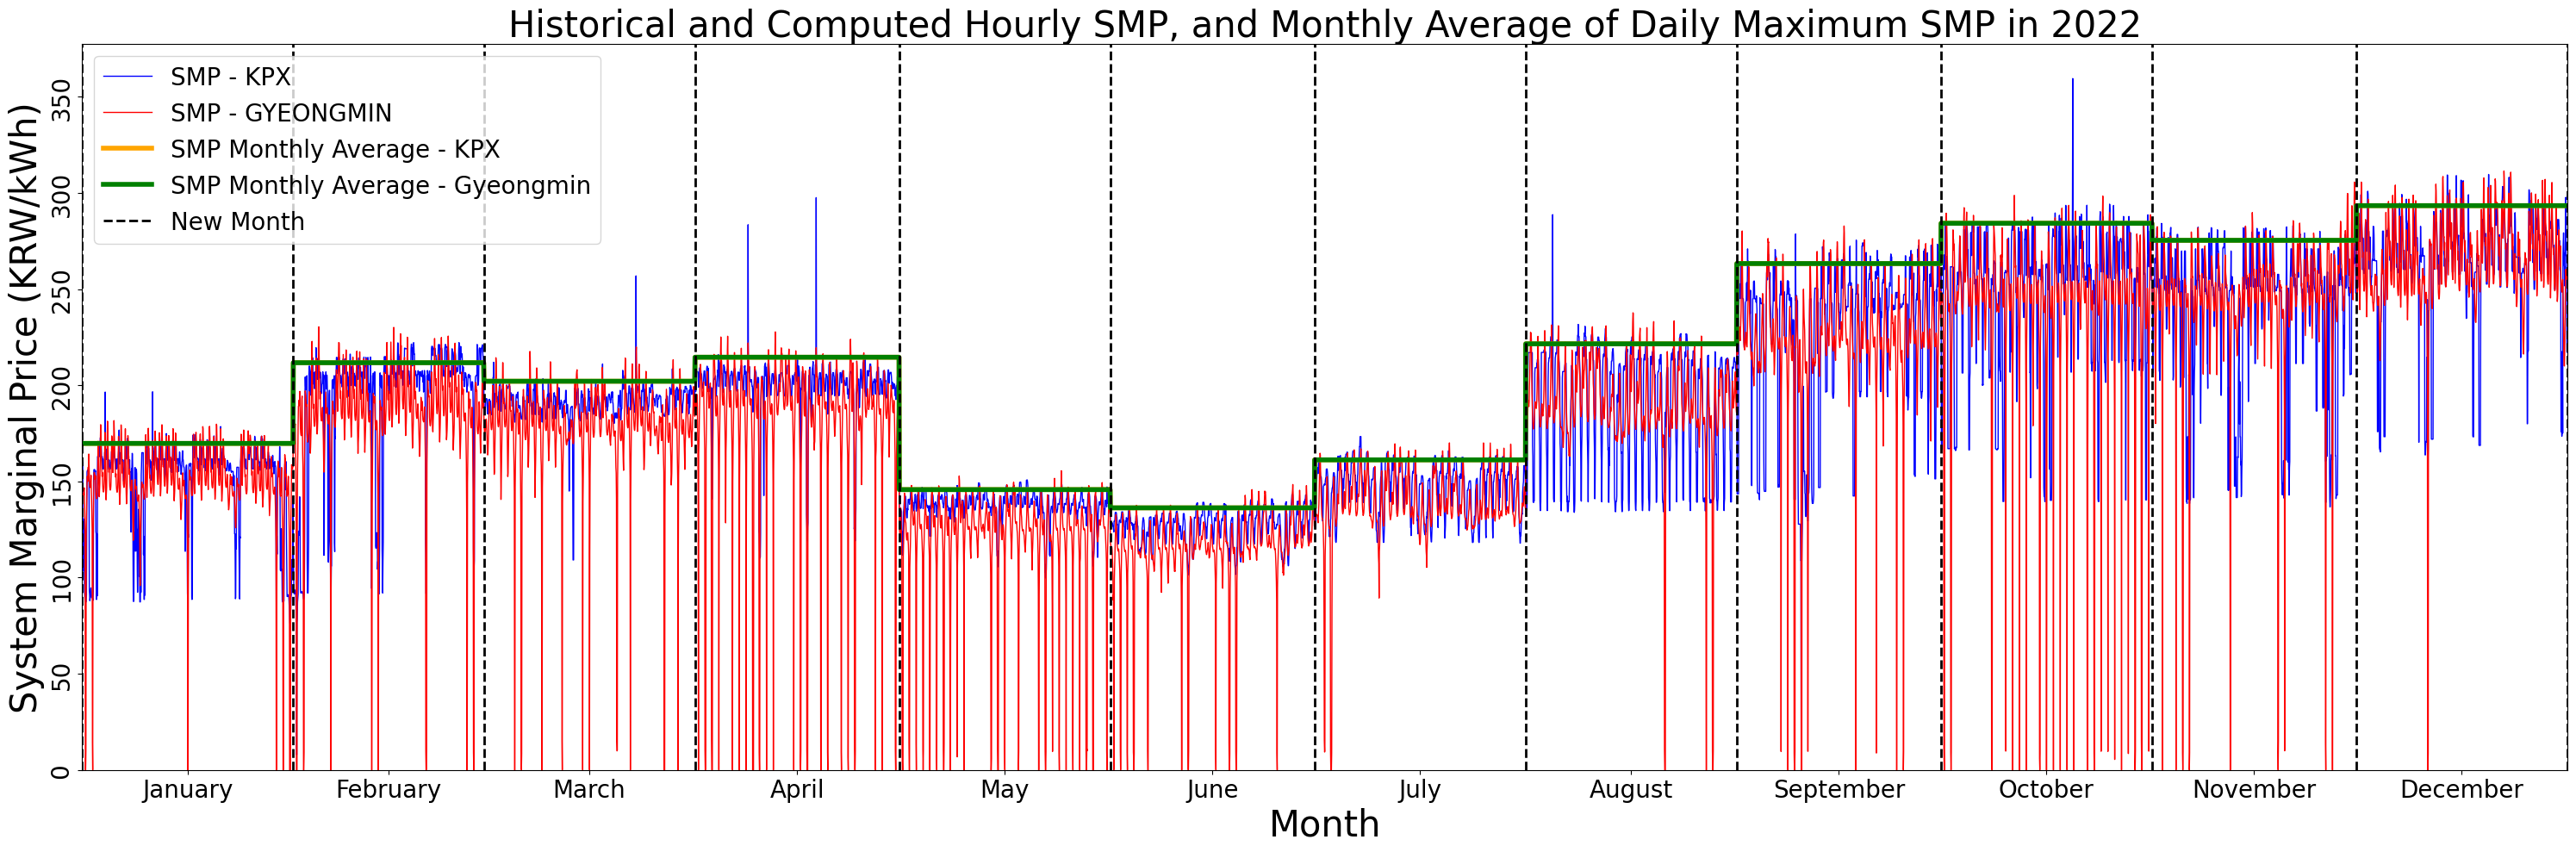

In [53]:
idx_hour_spc_start, idx_hour_spc_end = 0, 8759
iterator = range(idx_hour_spc_start, (idx_hour_spc_end + 1))

fig, ax = plt.subplots(1, 1, figsize=(30, 10))
# SMP
l0, = ax.plot(iterator, smp_real[idx_hour_spc_start:idx_hour_spc_end+1], color="blue", label="SMP - KPX", linewidth=1)
l1, = ax.plot(iterator, results.smp[idx_hour_spc_start:idx_hour_spc_end+1], color="red", label="SMP - GYEONGMIN", linewidth=1)
l2, = ax.plot(iterator, smp_real_monthly_mean_daily_max_8760[idx_hour_spc_start:idx_hour_spc_end+1], color="orange", label="SMP Monthly Average - KPX", linewidth=4)
l3, = ax.plot(iterator, smp_results_monthly_mean_daily_max_8760[idx_hour_spc_start:idx_hour_spc_end+1], color="green", label="SMP Monthly Average - Gyeongmin", linewidth=4)
# MONTH
ymin, ymax = ax.get_ylim()
ymin = ymin if results.smp[idx_hour_spc_start:idx_hour_spc_end+1].min() < 0 else 0
l4= ax.vlines(x=idxs_hour_month_start.tolist() + [idxs_hour_month_end[-1]], ymin=ymin, ymax=ymax, colors="black", linewidth=2, linestyles="--", label="New Month")
# TITLE
ax.set_title("Historical and Computed Hourly SMP, and Monthly Average of Daily Maximum SMP in 2022", fontsize=30)
ax.set_xlabel("Month", fontsize=30)
ax.set_ylabel("System Marginal Price (KRW/kWh)", fontsize=30)
# TICKS
ax.set_xticks(((idxs_hour_month_start + idxs_hour_month_end) / 2).tolist())
ax.set_xticklabels(list(month_names.values()))
ax.tick_params(axis='both', labelsize=20)
[label.set_rotation(90) or label.set_va('center') for label in ax.get_yticklabels()]
[label.set_rotation(90) or label.set_va('center') or label.set_fontsize(20) for label in ax2.get_yticklabels()]
# LEGEND
lines = [l0, l1, l2, l3, l4,]
ax.legend(lines, [line.get_label() for line in lines], loc="upper left", fontsize=20)
# LIM
ax.set_xlim((idx_hour_spc_start - 0.5, idx_hour_spc_end + .5))
ax.set_ylim((ymin, ymax))

fig.tight_layout()
plt.show(fig) # let's ignore the outliers bringing the monthly average upwards for smp_real for now # this is just more to do with statistics, not the core logic of the model 2 development (cost function tuning)

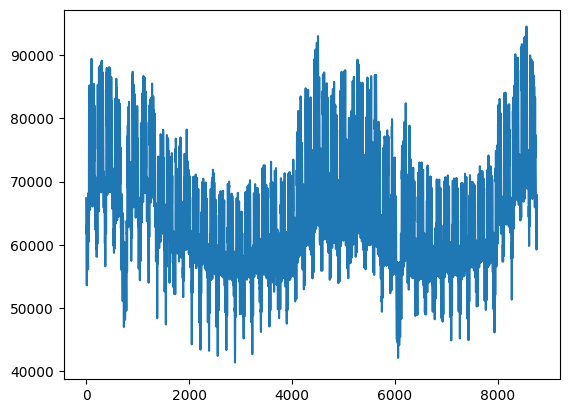

In [54]:
plt.plot(demand.total)